<a href="https://colab.research.google.com/github/vlamen/tue-deeplearning/blob/main/assignments/assignment_2_3/a3_skeleton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Group Number:

# Student 1:

# Student 2:

# Student 3:

# Downloading Data and Preliminaries

In [1]:
import pickle
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

from zipfile import ZipFile
import requests
import io

In [2]:
def load_zip(url):
    response = requests.get(url)
    response.raise_for_status()
    zipf = ZipFile(io.BytesIO(response.content))
    return {name: zipf.read(name) for name in zipf.namelist()}

def load_pickle(zipfile, fn):
    return pickle.load(io.BytesIO(zipfile[fn]))

In [3]:
data = load_zip('https://surfdrive.surf.nl/files/index.php/s/cwqGaS22KXgnXtg/download')

    
"""
simulation_{train, valid, test} is stored as a list of simulations. 
Each simulation is a numpy array of size (t, 2): For t timesteps an x and y coordinate of our particle.
"""
simulation_train = load_pickle(data, 'data/train/simulation.pickle')  # 3.1 + 3.2
simulation_valid = load_pickle(data, 'data/valid/simulation.pickle')  # 3.1 + 3.2
simulation_test = load_pickle(data, 'data/test/simulation.pickle')  # 3.1 + 3.2

"""
charges_{train, valid, test} is stored as a list of simulation-charges. 
These charges are stored as numpy arrays of size (3,): One value for each charge.
"""
charges_train = load_pickle(data, 'data/train/charges.pickle')  # 3.1
charges_valid = load_pickle(data, 'data/valid/charges.pickle')  # 3.1
charges_test = load_pickle(data, 'data/test/charges.pickle')  # 3.1

"""
simulation_continued_{train, valid, test} is stored as a list of simulations. 
Each simulation is a numpy array of size (t, 2): For t timesteps an x and y coordinate of our particle.
"""
simulation_continued_train = load_pickle(data, 'data/train/simulation_continued.pickle')  # 3.2
simulation_continued_valid = load_pickle(data, 'data/valid/simulation_continued.pickle')  # 3.2
simulation_continued_test = load_pickle(data, 'data/test/simulation_continued.pickle')  # 3.2

"""
Note that the indices are shared throughout the different lists, e.g., for the 4th training simulation:
simulation_train[3] contains its initial simulation
charges_train[3] contains the charges associated with the simulation
simulation_continued_train[3] contains the continuation of the simulation 
                --> simulation_continued_train[3][0] is the state after simulation_train[3][-1]
"""
pass

In [4]:
print('Overview of no. datapoints:\n')

print('Task 3.1:')
print(f'{len(simulation_train)} train, {len(simulation_valid)} validation, {len(simulation_test)} test simulations')
print(f'{len(charges_train)} train, {len(charges_valid)} validation, {len(charges_test)} test charge pairs')
print()

print('Task 3.2:')
print('Since len(simulation_continued_train) < len(simulation_train), we can only use a subset of initial simulations')
print('We cut simulation_train down to the first 150 samples in simulation_train_task32')
simulation_train_task32 = simulation_train[:150]
print(f'{len(simulation_train_task32)} train, {len(simulation_valid)} validation, {len(simulation_test)} test simulations')
print(f'{len(simulation_continued_train)} train, {len(simulation_continued_valid)} validation, {len(simulation_continued_test)} test continuations')

print(f"""
For task 3.1, use:
{chr(10).join(["simulation_{} + charges_{}".format(t, t) for t in ["train", "valid", "test"]])}

For task 3.2, use:
{chr(10).join(["simulation_{} + simulation_continued_{}".format(*((t[0], t[1]) if isinstance(t, tuple) else (t, t))) for t in [("train_task32", "train"), "valid", "test"]])}
""")


Overview of no. datapoints:

Task 3.1:
800 train, 100 validation, 100 test simulations
800 train, 100 validation, 100 test charge pairs

Task 3.2:
Since len(simulation_continued_train) < len(simulation_train), we can only use a subset of initial simulations
We cut simulation_train down to the first 150 samples in simulation_train_task32
150 train, 100 validation, 100 test simulations
150 train, 100 validation, 100 test continuations

For task 3.1, use:
simulation_train + charges_train
simulation_valid + charges_valid
simulation_test + charges_test

For task 3.2, use:
simulation_train_task32 + simulation_continued_train
simulation_valid + simulation_continued_valid
simulation_test + simulation_continued_test



In [5]:
print('Print some shapes:\n')
for i in range(3):
    print('simulation_train[{}].shape:'.format(i), simulation_train[i].shape, '-> (t, 2), (x, y) at every t)')
    print('charges_train[{}].shape:'.format(i), charges_train[i].shape, '-> charges for the simulation')
    print('simulation_continued_train[{}].shape:'.format(i), simulation_continued_train[i].shape, '-> (t, 2), (x, y) at every t)')
    print('----\n')

Print some shapes:

simulation_train[0].shape: (103, 2) -> (t, 2), (x, y) at every t)
charges_train[0].shape: (3,) -> charges for the simulation
simulation_continued_train[0].shape: (54, 2) -> (t, 2), (x, y) at every t)
----

simulation_train[1].shape: (97, 2) -> (t, 2), (x, y) at every t)
charges_train[1].shape: (3,) -> charges for the simulation
simulation_continued_train[1].shape: (45, 2) -> (t, 2), (x, y) at every t)
----

simulation_train[2].shape: (99, 2) -> (t, 2), (x, y) at every t)
charges_train[2].shape: (3,) -> charges for the simulation
simulation_continued_train[2].shape: (47, 2) -> (t, 2), (x, y) at every t)
----



In [6]:
def plot_example(x, x_gt=None, x_pred=None, fn=None):
    charge_locations = np.array([[-1.53846154, -1.53846154],
                                 [ 1.53846154, -1.53846154],
                                 [ 0.        ,  1.53846154]])  # charge locations are fixed
    fig = plt.figure()
    axes = plt.gca()
    axes.set_xlim([-5., 5.])
    axes.set_ylim([-5., 5.])
    cmap = matplotlib.cm.get_cmap('tab20')
    plt.plot(x[:, 0], x[:, 1], color=cmap(0))
    plt.plot(x[0, 0], x[0, 1], 'd', color=cmap(1))
    fig.set_size_inches(5, 5)
    for charge in charge_locations:
        plt.plot(charge[0], charge[1], 'd', color='black')
    if x_gt is not None:
        plt.plot(x_gt[:, 0], x_gt[:, 1], color='red', linewidth=.5)
    if x_pred is not None:
        plt.plot(x_pred[:, 0], x_pred[:, 1], color='green', linestyle='--')
    if fn is None:
        plt.show()
    else:
        plt.savefig(fn)

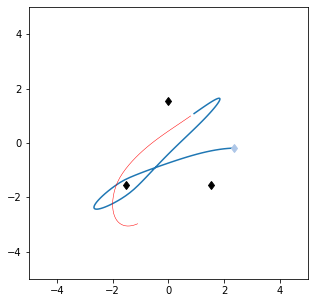

Charges are [-0.79686436 -0.80147746 -0.6384248 ]


In [7]:
test_idx = np.random.randint(150)
plot_example(simulation_train[test_idx], simulation_continued_train[test_idx])
print(f'Charges are {charges_train[test_idx]}')

# Task 3.1

## Data Handling and Preprocessing

In [8]:
# Pick the best device
import torch

def try_device(device):
    # Try to put an array on given device. If successful, return device. Else, 'cpu'.
    x = torch.ones((1,))
    try:
        x.to(device)
        return device
    except:
        return 'cpu'

device = try_device('cuda')
if device == 'cpu':
    # mps doesn't support our model (yet?)
    # device = try_device('mps')
    pass


print(f'Device is set to {device}')

Device is set to cpu


In [9]:
# Task 3.1: Using the positions of positively charged particle p1 during a simulation, predict the
# values of negative charges c2, c3, c4
# input = t locations (x, y) of p1 particle, value of t is not fixed

from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pack_sequence, pad_sequence

class SimulationData(Dataset):
    def __init__(self, sim, charges):
        self.sim = sim
        self.charges = charges

    def __len__(self):
        return len(self.sim)

    def __getitem__(self, idx):
        return self.sim[idx], self.charges[idx]

# Create data loader
def collate(data):
    # Sort data in order of decreasing sequence length
    data = list(reversed(sorted(data, key=lambda d: len(d[0]))))
    xs = pad_sequence([torch.tensor(x).float() for x, _ in data], batch_first=True)
    ys = torch.stack([torch.tensor(y).float() for _, y in data])
    return xs, ys

# Batch size needs to evenly divide all train, valid, test sizes (800, 100, 100)
batch_size = 5
train_dl = DataLoader(SimulationData(simulation_train, charges_train), batch_size=batch_size, shuffle=True, collate_fn=collate)
valid_dl = DataLoader(SimulationData(simulation_valid, charges_valid), batch_size=batch_size, shuffle=True, collate_fn=collate)


In [10]:
print(simulation_train[0].shape)
# Test data loader
xs, ys = next(iter(train_dl))
print(len(xs))
print(xs[0].shape, ys[0].shape)

(103, 2)
5
torch.Size([106, 2]) torch.Size([3])


In [11]:
# Baseline model: predict the mean value of each charge in the training set
baseline_values = torch.tensor(np.array(charges_train).mean(axis=0))
def baseline_predict(xs):
    batch = xs.shape[0]
    return baseline_values.expand(batch, 3)

loss_fn = lambda y, y_pred: (y - y_pred).abs().sum()

# Baseline error?

def avg_err(model, dl, loss_fn=torch.nn.L1Loss(reduction='sum')):
    loss = 0
    n_samples = 0
    for x, y in dl:
        y_pred = model(x)
        loss += loss_fn(y, y_pred)
        n_samples += x.shape[0]
    return loss / n_samples


print(f'Baseline L1 train error: {avg_err(baseline_predict, train_dl)}')
print(f'Baseline L1 validation error: {avg_err(baseline_predict, valid_dl)}')

Baseline L1 train error: 0.7429322004318237
Baseline L1 validation error: 0.7968491911888123


## Model Implementation

In [12]:
class Model_3_1(torch.nn.Module):
    def __init__(self, hidden_dim, n_layers, batch_size):
        super(Model_3_1, self).__init__()
        # input/output size are fixed based on the task description
        input_dim = 2
        output_dim = 3

        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.batch_size = batch_size
        
        self.gru = torch.nn.GRU(input_dim, hidden_dim, n_layers, batch_first=True)
        self.relu = torch.nn.ReLU()
        self.fc = torch.nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        h = self.init_hidden()
        out, h = self.gru(x, h)
        out = self.fc(self.relu(out[:,-1]))
        return out
    
    def init_hidden(self):
        # from example of https://pytorch.org/docs/stable/generated/torch.nn.GRU.html
        h0 = torch.randn(self.n_layers, self.batch_size, self.hidden_dim).to(device)
        return h0

xs = xs.to(device)
model_3_1 = Model_3_1(30, 5, batch_size).to(device)
print(model_3_1(xs).shape)

torch.Size([5, 3])


## Model Training

In [13]:
from tqdm import tqdm

def fit_3_1(model, train_dl, valid_dl, n_epochs):
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
    loss_func = torch.nn.L1Loss()

    for i in range(n_epochs):
        print(f'Begin epoch {i + 1}/{n_epochs}')
        for x, y in tqdm(train_dl):
            x = x.to(device=device)
            y = y.to(device=device).float()
            y_pred = model(x)
            loss = loss_func(y, y_pred)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        with torch.no_grad():
            print(f'L1 train error: {avg_err(model, train_dl)}')
            print(f'L1 validation error: {avg_err(model, valid_dl)}')

In [20]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

hidden_size = 30
n_layers = 5
model_3_1 = Model_3_1(hidden_size, n_layers, batch_size).to(device)
print(f'Model has {count_parameters(model_3_1)} parameters')
epochs = 50
fit_3_1(model_3_1, train_dl, valid_dl, epochs)

Model has 25473 parameters
Begin epoch 1/50


100%|██████████| 160/160 [00:12<00:00, 12.42it/s]


L1 train error: 0.6503742933273315
L1 validation error: 0.6855818033218384
Begin epoch 2/50


100%|██████████| 160/160 [00:12<00:00, 12.54it/s]


L1 train error: 0.5694036483764648
L1 validation error: 0.587999165058136
Begin epoch 3/50


100%|██████████| 160/160 [00:12<00:00, 12.53it/s]


L1 train error: 0.47914445400238037
L1 validation error: 0.4728028476238251
Begin epoch 4/50


100%|██████████| 160/160 [00:12<00:00, 12.46it/s]


L1 train error: 0.438493549823761
L1 validation error: 0.45304593443870544
Begin epoch 5/50


100%|██████████| 160/160 [00:13<00:00, 12.25it/s]


L1 train error: 0.4651319980621338
L1 validation error: 0.4666794538497925
Begin epoch 6/50


100%|██████████| 160/160 [00:12<00:00, 12.55it/s]


L1 train error: 0.4301636815071106
L1 validation error: 0.4542055130004883
Begin epoch 7/50


100%|██████████| 160/160 [00:12<00:00, 12.44it/s]


L1 train error: 0.40695106983184814
L1 validation error: 0.4297737777233124
Begin epoch 8/50


100%|██████████| 160/160 [00:12<00:00, 12.61it/s]


L1 train error: 0.3942517340183258
L1 validation error: 0.4309663772583008
Begin epoch 9/50


100%|██████████| 160/160 [00:12<00:00, 12.50it/s]


L1 train error: 0.38608860969543457
L1 validation error: 0.4098789691925049
Begin epoch 10/50


100%|██████████| 160/160 [00:13<00:00, 12.13it/s]


L1 train error: 0.39531344175338745
L1 validation error: 0.4256073832511902
Begin epoch 11/50


100%|██████████| 160/160 [00:13<00:00, 12.24it/s]


L1 train error: 0.3756287395954132
L1 validation error: 0.37347638607025146
Begin epoch 12/50


100%|██████████| 160/160 [00:12<00:00, 12.43it/s]


L1 train error: 0.3662091791629791
L1 validation error: 0.35850563645362854
Begin epoch 13/50


100%|██████████| 160/160 [00:12<00:00, 12.33it/s]


L1 train error: 0.35658568143844604
L1 validation error: 0.3635188341140747
Begin epoch 14/50


100%|██████████| 160/160 [00:12<00:00, 12.34it/s]


L1 train error: 0.3146274983882904
L1 validation error: 0.3439885973930359
Begin epoch 15/50


100%|██████████| 160/160 [00:12<00:00, 12.62it/s]


L1 train error: 0.33082953095436096
L1 validation error: 0.3568885028362274
Begin epoch 16/50


100%|██████████| 160/160 [00:12<00:00, 12.57it/s]


L1 train error: 0.31605738401412964
L1 validation error: 0.32317811250686646
Begin epoch 17/50


100%|██████████| 160/160 [00:12<00:00, 12.60it/s]


L1 train error: 0.31765323877334595
L1 validation error: 0.3110068142414093
Begin epoch 18/50


100%|██████████| 160/160 [00:12<00:00, 12.53it/s]


L1 train error: 0.2869611382484436
L1 validation error: 0.3013763129711151
Begin epoch 19/50


100%|██████████| 160/160 [00:12<00:00, 12.64it/s]


L1 train error: 0.2793547511100769
L1 validation error: 0.2911866307258606
Begin epoch 20/50


100%|██████████| 160/160 [00:12<00:00, 12.65it/s]


L1 train error: 0.2887084484100342
L1 validation error: 0.31249240040779114
Begin epoch 21/50


100%|██████████| 160/160 [00:12<00:00, 12.69it/s]


L1 train error: 0.2691543996334076
L1 validation error: 0.2875034809112549
Begin epoch 22/50


100%|██████████| 160/160 [00:12<00:00, 12.52it/s]


L1 train error: 0.26190489530563354
L1 validation error: 0.2779183089733124
Begin epoch 23/50


100%|██████████| 160/160 [00:16<00:00,  9.74it/s]


L1 train error: 0.2718191146850586
L1 validation error: 0.2842063009738922
Begin epoch 24/50


100%|██████████| 160/160 [00:12<00:00, 12.58it/s]


L1 train error: 0.25695520639419556
L1 validation error: 0.27646270394325256
Begin epoch 25/50


100%|██████████| 160/160 [00:12<00:00, 12.43it/s]


L1 train error: 0.24717697501182556
L1 validation error: 0.2630058825016022
Begin epoch 26/50


100%|██████████| 160/160 [00:12<00:00, 12.48it/s]


L1 train error: 0.2268102467060089
L1 validation error: 0.2543950378894806
Begin epoch 27/50


100%|██████████| 160/160 [00:12<00:00, 12.49it/s]


L1 train error: 0.23177629709243774
L1 validation error: 0.2602672874927521
Begin epoch 28/50


100%|██████████| 160/160 [00:12<00:00, 12.52it/s]


L1 train error: 0.25984808802604675
L1 validation error: 0.2915298342704773
Begin epoch 29/50


100%|██████████| 160/160 [00:12<00:00, 12.52it/s]


L1 train error: 0.22175781428813934
L1 validation error: 0.2590576410293579
Begin epoch 30/50


100%|██████████| 160/160 [00:13<00:00, 12.22it/s]


L1 train error: 0.23567719757556915
L1 validation error: 0.2680894732475281
Begin epoch 31/50


100%|██████████| 160/160 [00:13<00:00, 11.68it/s]


L1 train error: 0.21252626180648804
L1 validation error: 0.2237851917743683
Begin epoch 32/50


100%|██████████| 160/160 [00:12<00:00, 12.35it/s]


L1 train error: 0.2107575386762619
L1 validation error: 0.23616820573806763
Begin epoch 33/50


100%|██████████| 160/160 [00:12<00:00, 12.33it/s]


L1 train error: 0.21081380546092987
L1 validation error: 0.25655603408813477
Begin epoch 34/50


100%|██████████| 160/160 [00:12<00:00, 12.56it/s]


L1 train error: 0.21527938544750214
L1 validation error: 0.24522127211093903
Begin epoch 35/50


100%|██████████| 160/160 [00:13<00:00, 11.63it/s]


L1 train error: 0.21920740604400635
L1 validation error: 0.2528992295265198
Begin epoch 36/50


100%|██████████| 160/160 [00:12<00:00, 12.46it/s]


L1 train error: 0.22146880626678467
L1 validation error: 0.2614203095436096
Begin epoch 37/50


100%|██████████| 160/160 [00:12<00:00, 12.47it/s]


L1 train error: 0.22151592373847961
L1 validation error: 0.24773246049880981
Begin epoch 38/50


100%|██████████| 160/160 [00:12<00:00, 12.48it/s]


L1 train error: 0.19681547582149506
L1 validation error: 0.22868502140045166
Begin epoch 39/50


100%|██████████| 160/160 [00:13<00:00, 12.11it/s]


L1 train error: 0.19346284866333008
L1 validation error: 0.2423447072505951
Begin epoch 40/50


100%|██████████| 160/160 [00:13<00:00, 12.27it/s]


L1 train error: 0.20484121143817902
L1 validation error: 0.23353563249111176
Begin epoch 41/50


100%|██████████| 160/160 [00:13<00:00, 12.18it/s]


L1 train error: 0.2123049795627594
L1 validation error: 0.2505665123462677
Begin epoch 42/50


100%|██████████| 160/160 [00:12<00:00, 12.57it/s]


L1 train error: 0.2090759128332138
L1 validation error: 0.2307688593864441
Begin epoch 43/50


100%|██████████| 160/160 [00:12<00:00, 12.47it/s]


L1 train error: 0.1853846162557602
L1 validation error: 0.2239481806755066
Begin epoch 44/50


100%|██████████| 160/160 [00:12<00:00, 12.37it/s]


L1 train error: 0.20591293275356293
L1 validation error: 0.24895226955413818
Begin epoch 45/50


100%|██████████| 160/160 [00:12<00:00, 12.53it/s]


L1 train error: 0.17945648729801178
L1 validation error: 0.1915401816368103
Begin epoch 46/50


100%|██████████| 160/160 [00:12<00:00, 12.47it/s]


L1 train error: 0.19271083176136017
L1 validation error: 0.241977259516716
Begin epoch 47/50


100%|██████████| 160/160 [00:12<00:00, 12.59it/s]


L1 train error: 0.20016302168369293
L1 validation error: 0.2358424812555313
Begin epoch 48/50


100%|██████████| 160/160 [00:12<00:00, 12.63it/s]


L1 train error: 0.18636681139469147
L1 validation error: 0.20521996915340424
Begin epoch 49/50


100%|██████████| 160/160 [00:12<00:00, 12.65it/s]


L1 train error: 0.19453464448451996
L1 validation error: 0.23483771085739136
Begin epoch 50/50


100%|██████████| 160/160 [00:12<00:00, 12.65it/s]


L1 train error: 0.17987892031669617
L1 validation error: 0.2144988775253296


## Evaluation

In [15]:
#todo

# Task 3.2

## Data Handling and Preprocessing

In [16]:
#todo

## Model Implementation

In [17]:
#todo

## Model Training

In [18]:
#todo

## Evaluation

In [19]:
#todo